In [1]:
import pandas as pd
import numpy as np

df_Model = pd.read_csv("../Data Model/IN_Model.csv")
smaller_df = pd.read_csv("../Clean Data/Spread_Cleaned_IN.csv")
df_Model.info()
smaller_df.info()

<ipython-input-1-e3c2bae97a40>:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086 entries, 0 to 1085
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                1086 non-null   object 
 1   PX_LAST             1086 non-null   float64
 2   GARCH_Volatility    1086 non-null   float64
 3   Sigma_Annualized    1086 non-null   float64
 4   NIFVIX              1086 non-null   float64
 5   IN003M              1086 non-null   float64
 6   Daily_STIR          1086 non-null   float64
 7   Theoretical_Spread  1086 non-null   float64
dtypes: float64(7), object(1)
memory usage: 63.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         187 non-null    object 
 1   PX_LAST      187 non-null    float64
 2   PX_VOLUME_x  187 non-null    float64
 3   NIFVIX       187 non-null    flo

In [5]:
import pandas as pd
import numpy as np

df_Model['Date'] = pd.to_datetime(df_Model['Date'])
smaller_df['Date'] = pd.to_datetime(smaller_df['Date'])
joined_df = pd.merge(df_Model, smaller_df, on='Date', suffixes=('', '_smaller'))
joined_df = joined_df.drop(columns=['PX_LAST_smaller', 'PX_VOLUME_x', 'PX_VOLUME_y', 'NIFVIX_smaller', 'IN003M_smaller'])

initial_investment = 1000
joined_df['CFD_Ask'] = joined_df['PX_LAST'] + (joined_df['Theoretical_Spread'] / 2)
joined_df['CFD_Bid'] = joined_df['PX_LAST'] - (joined_df['Theoretical_Spread'] / 2)

# Leverage limits
upper_leverage = 5  # upper leverage limit proxy from NIFTY50 futures margin requirement of 20%
lower_leverage = 2   # lower leverage limit assumed

# Calculate CFD units for upper and lower leverage on the first day (initial CFD units)
joined_df['CFD_Units_Upper'] = (initial_investment * upper_leverage) / joined_df['CFD_Ask'].iloc[0]
joined_df['CFD_Units_Lower'] = (initial_investment * lower_leverage) / joined_df['CFD_Ask'].iloc[0]

# Calculate price delta
joined_df['Price_Delta_Upper'] = joined_df['CFD_Units_Upper'] * (joined_df['CFD_Bid'] - joined_df['CFD_Bid'].shift(1)).fillna(0)
joined_df['Price_Delta_Lower'] = joined_df['CFD_Units_Lower'] * (joined_df['CFD_Bid'] - joined_df['CFD_Bid'].shift(1)).fillna(0)

# Calculate cost of carry based on leverage levels
joined_df['Cost_of_Carry_Upper'] = initial_investment * (upper_leverage - 1) * joined_df['Daily_STIR']
joined_df['Cost_of_Carry_Lower'] = initial_investment * (lower_leverage - 1) * joined_df['Daily_STIR']
joined_df.loc[0, 'Cost_of_Carry_Upper'] = 0
joined_df.loc[0, 'Cost_of_Carry_Lower'] = 0

# Calculate cumulative cost of carry
joined_df['Cumulative_Cost_Upper'] = joined_df['Cost_of_Carry_Upper'].cumsum()
joined_df['Cumulative_Cost_Lower'] = joined_df['Cost_of_Carry_Lower'].cumsum()
joined_df.loc[0, 'Cumulative_Cost_Upper'] = 0
joined_df.loc[0, 'Cumulative_Cost_Lower'] = 0

# Calculate portfolio values
joined_df['Portfolio_Value_Upper'] = initial_investment + joined_df['Price_Delta_Upper'].cumsum() - joined_df['Cumulative_Cost_Upper']
joined_df['Portfolio_Value_Lower'] = initial_investment + joined_df['Price_Delta_Lower'].cumsum() - joined_df['Cumulative_Cost_Lower']

result_df = joined_df[['Date', 'PX_LAST', 'GARCH_Volatility', 'Sigma_Annualized', 'NIFVIX', 
                       'IN003M', 'Daily_STIR', 'CFD_Ask', 'CFD_Bid', 
                       'Portfolio_Value_Upper', 'Portfolio_Value_Lower', 'Cumulative_Cost_Upper', 'Cumulative_Cost_Lower']]

result_df.to_csv("Portfolio_Value_IN.csv", index=False)
result_df.head()

,Date,PX_LAST,GARCH_Volatility,Sigma_Annualized,NIFVIX,IN003M,Daily_STIR,CFD_Ask,CFD_Bid,Portfolio_Value_Upper,Portfolio_Value_Lower,Cumulative_Cost_Upper,Cumulative_Cost_Lower
0,2023-11-28,17741.80,0.005811,0.092240,0.121750,0.0724,0.000287,17743.095381,17740.504619,1000.000000,1000.000000,0.000000,0.000000
1,2023-11-29,17904.10,0.005817,0.092347,0.127075,0.0724,0.000287,17905.408751,17902.791249,1044.583127,1018.005632,1.149206,0.287302
2,2023-11-30,17987.95,0.006196,0.098365,0.126900,0.0725,0.000288,17989.350569,17986.549431,1067.035369,1027.159148,2.300000,0.575000
3,2023-12-01,18115.35,0.006099,0.096813,0.123825,0.0724,0.000287,18116.738235,18113.961765,1101.790927,1041.233752,3.449206,0.862302
4,2023-12-04,18448.50,0.006201,0.098435,0.129925,0.0723,0.000287,18449.937442,18447.062558,1194.511032,1078.493936,4.596825,1.149206


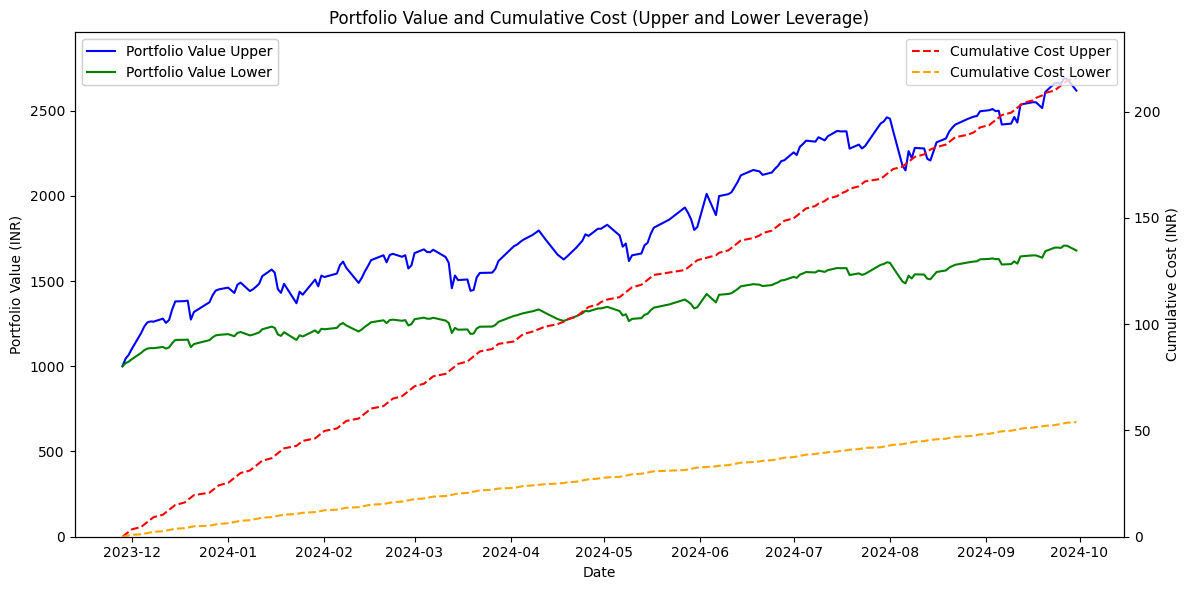

In [4]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_title("Portfolio Value and Cumulative Cost (Upper and Lower Leverage)")
ax1.plot(result_df['Date'], result_df['Portfolio_Value_Upper'], color='b', label='Portfolio Value Upper', linewidth=1.5)
ax1.plot(result_df['Date'], result_df['Portfolio_Value_Lower'], color='g', label='Portfolio Value Lower', linewidth=1.5)
ax1.set_xlabel("Date")
ax1.set_ylabel("Portfolio Value (INR)")
ax1.set_ylim(0, max(result_df[['Portfolio_Value_Upper', 'Portfolio_Value_Lower']].max()) * 1.1) 

portfolio_legend = ax1.legend(loc="upper left")
ax1.add_artist(portfolio_legend)

ax2 = ax1.twinx()
ax2.plot(result_df['Date'], result_df['Cumulative_Cost_Upper'], color='r', label='Cumulative Cost Upper', linestyle='--', linewidth=1.5)
ax2.plot(result_df['Date'], result_df['Cumulative_Cost_Lower'], color='orange', label='Cumulative Cost Lower', linestyle='--', linewidth=1.5)
ax2.set_ylabel("Cumulative Cost (INR)")
ax2.set_ylim(0, max(result_df[['Cumulative_Cost_Upper', 'Cumulative_Cost_Lower']].max()) * 1.1)

cumulative_cost_legend = ax2.legend(loc="upper right")

fig.tight_layout()
plt.show()
